In [1]:
# Get all the variables, classes and functions we defined in the previous lessons
from vars.week_3 import *
from vars.week_4 import *
from vars.week_5 import *

# 6. More complex modules

## 6.1 Subclassing nn.Module
So far, we've looked at how to put together simple models using Pytorch's `nn.Sequential` function. Remember, all it does is sequentially line up the layers and directs the output of one into the input of the next. However, there are cases where we don't want out data to flow in such a linear fashion. A good example is a Residual Network or ResNet, which applies shortcuts between its layers. This cannot be done using a simple `nn.Sequential` construction. In such cases, it becomes necessary to sub-class the `nn.Module` class and create our own.

In [7]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        if downsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, inp):
        shortcut = self.shortcut(inp)
        inp = nn.ReLU()(self.bn1(self.conv1(inp)))
        inp = nn.ReLU()(self.bn2(self.conv2(inp)))
        inp = inp + shortcut  # The magic bit that cannot be done with nn.Sequential!
        return nn.ReLU()(inp)
    


class ResNet(nn.Module):
    def __init__(self, in_channels, resblock, outputs):
        super().__init__()
        self.layer0_conv = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3)
        self.layer0_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer0_bn   = nn.BatchNorm2d(64)
        self.layer0_relu = nn.ReLU()

        self.layer1_res1 = resblock(64, 64, downsample=False)
        self.layer1_res2 = resblock(64, 64, downsample=False)

        self.layer2_res1 = resblock(64, 128, downsample=True)
        self.layer2_res2 = resblock(128, 128, downsample=False)

        self.layer3_res1 = resblock(128, 256, downsample=True)
        self.layer3_res2 = resblock(256, 256, downsample=False)

        self.layer4_res1 = resblock(256, 512, downsample=True)
        self.layer4_res2 = resblock(512, 512, downsample=False)

        self.gap         = nn.AdaptiveAvgPool2d(1)
        self.flat        = nn.Flatten() 
        self.fc          = nn.Linear(512, outputs)

    def forward(self, inp):
        inp = self.layer0_conv(inp)
        inp = self.layer0_pool(inp)
        inp = self.layer0_bn(inp)
        inp = self.layer0_relu(inp)
        
        inp = self.layer1_res1(inp)
        inp = self.layer1_res2(inp)
        
        inp = self.layer2_res1(inp)
        inp = self.layer2_res2(inp)
        
        inp = self.layer3_res1(inp)
        inp = self.layer3_res2(inp)
        
        inp = self.layer4_res1(inp)
        inp = self.layer4_res2(inp)
            
        inp = self.gap(inp)
        inp = self.flat(inp)
        inp = self.fc(inp)

        return inp
    

# convenience function
def get_resnet():
    return ResNet(1, ResBlock, outputs=10)


# Print model summary
summary(get_resnet(), input_size=(1, 28, 28), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           3,200
         MaxPool2d-2             [-1, 64, 7, 7]               0
       BatchNorm2d-3             [-1, 64, 7, 7]             128
              ReLU-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]          36,928
       BatchNorm2d-6             [-1, 64, 7, 7]             128
            Conv2d-7             [-1, 64, 7, 7]          36,928
       BatchNorm2d-8             [-1, 64, 7, 7]             128
          ResBlock-9             [-1, 64, 7, 7]               0
           Conv2d-10             [-1, 64, 7, 7]          36,928
      BatchNorm2d-11             [-1, 64, 7, 7]             128
           Conv2d-12             [-1, 64, 7, 7]          36,928
      BatchNorm2d-13             [-1, 64, 7, 7]             128
         ResBlock-14             [-1, 6

In [ ]:
# We do not need to define a new train function as the only changes have been to the internal
# structure of the model, not any of its inputs or outputs, so we can keep using
# the old one - very handy!

# loading data
train_dl, val_dl, test_dl = load_data(DATA_PATH, batch_sz=batch_sz)
dataloaders = {
    'train': train_dl,
    'val': val_dl,
    'test': test_dl
}

# setting device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

network = get_resnet()
optim = SGD(network.parameters(), lr=learning_rate)
lr_sch = ExponentialLR(optim, gamma=gamma)
network = network.to(device)
train_model_gpu_lr_conv_valid(device, network, epochs, dataloaders, optim, lr_sch)

## 6.2 Early stopping
Model training on a typical machine learning project is a time-consuming process. Sometimes, we may even want to run the same model multiple times with different parameters to see which ones work the best (a process known as hyper-parameter tuning). If a model is allowed to run for a long time despite not getting any better at learning, that's wasted time and computing power. We use early stopping to tackle this problem. This is a simple algorithm that just says whether or not the model should be stopped, based on its performance over time. 

To illustrate this concept, we define a class `EarlyStopper` that performs this check. Its should_stop method must be called every epoch with the current validation accuracy for that epoch

In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, tolerance=0):
        self.patience = patience           # How many epochs in a row the model is allowed to underperform    
        self.tolerance = tolerance         # How much leeway the model has (i.e. how close it can get to underperforming before it is counted as such)
        self.epoch_counter = 0             # Keeping track of how many epochs in a row were failed 
        self.max_validation_acc = np.NINF  # Keeping track of best metric so far

    def should_stop(self, validation_acc):
        if validation_acc > self.max_validation_acc:
            self.max_validation_acc = validation_acc
            self.epoch_counter = 0
        elif validation_acc < (self.max_validation_acc - self.tolerance):
            self.epoch_counter += 1
            if self.epoch_counter >= self.patience:
                return True
        return False 

## 6.3 Logging
We will also be using a logging tool called `tensorboard` to keep track of our metrics and visualise the performance of our model as it goes through its training cyle. The output of a Pytorch training run is typically stored in a directory called `runs` somewhere in the project root. We need to pass this directory to `tensorboard` so that it can display the progress of our runs for us. Let's import this module now.

In [ ]:
from torch.utils.tensorboard import SummaryWriter

## 6.4 Checkpointing
Finally, it is typical in machine learning pipelines to save the progress of a long-running training session every so often. Since it is such a time consuming process, chances are, sooner or later, one of any number of things outside the control of the programmer might interrupt the training (power outage, alien attack etc, etc.). If such a thing were to happen in the middle of a training cyle, that could mean days or weeks of training lost in an instant. It's STRONGLY recommended that you implement some kind of checkpointing functionality in your ML training pipeline. We define a save function below for this purpose:

In [ ]:
import os


# Saves a model to file, and names it after the current epoch
def save_checkpoint(model, epoch, save_dir):
    filename = f"checkpoint_{epoch}.pth"
    save_path = os.path.join(save_dir, filename)
    torch.save(model, save_path)

## 6.5 Final training loop 
Using all this information, we update our training function one last time.

For those of you keeping score, this training function now supports:
1. GPU training
2. Adaptive learning rates
3. Training and validation epochs
4. Early stopping
5. Logging metrics 
6. Model checkpointing

To avoid ending up with a ridiculously long name for our training function (`train_model_gpu_lr_conv_valid_stopping_logging_checkpoint` or some such), we shall rename it one last time to something sensible. 3 additional arguments have been added: the summary writer, the early stopper that we just wrote, and how often we want to save checkpoints


In [ ]:
def train_model_final(device, model, epochs, dataloaders, optimiser, lr_scheduler, writer, early_stopper, checkpoint_frequency):
    msg = ""
    for epoch in range(epochs):        
        #######################TRAINING STEP###################################
        model.train()  # set model to training mode 
        train_dl = dataloaders['train'] # select train dataloader
        
        total_steps_train = len(train_dl)
        correct_train = 0
        total_train = 0
        loss_train = 0
        
        for batch_num, (image_batch, label_batch) in enumerate(train_dl):
            batch_sz = len(image_batch)
            label_batch = label_batch.to(device)
            image_batch = image_batch.to(device).reshape(batch_sz, 1, 28, 28) 
            output = model(image_batch)
            loss_train = nn.CrossEntropyLoss()(output, label_batch)
                        
            optimiser.zero_grad()
            loss_train.backward()
            optimiser.step()
            
            preds_train = torch.argmax(output, dim=1)
            correct_train += int(torch.eq(preds_train, label_batch).sum())
            total_train += batch_sz
            minibatch_accuracy_train = 100 * correct_train / total_train
            
            #### Fancy printing stuff, you can ignore this! ######
            if (batch_num + 1) % 5 == 0:
                print(" " * len(msg), end='\r')
                msg = f'Train epoch[{epoch+1}/{epochs}], MiniBatch[{batch_num + 1}/{total_steps_train}], Loss: {loss_train.item():.5f}, Acc: {minibatch_accuracy_train:.5f}, LR: {lr_scheduler.get_last_lr()[0]:.5f}'
                print (msg, end='\r' if epoch < epochs else "\n",flush=True)
            #### Fancy printing stuff, you can ignore this! ######
        lr_scheduler.step()
        ########################################################################
        print("") # Create newline between progress bars
        #######################VALIDATION STEP##################################
        model.eval()  # set model to evaluation mode. This is very important, we do not want to update model weights in eval mode
        val_dl = dataloaders['val'] # select val dataloader
        
        total_steps_val = len(val_dl)
        correct_val = 0
        total_val = 0
        loss_val = 0
        
        for batch_num, (image_batch, label_batch) in enumerate(val_dl):
            batch_sz = len(image_batch)
            label_batch = label_batch.to(device)
            image_batch = image_batch.to(device).reshape(batch_sz, 1, 28, 28) 
            
            with torch.no_grad(): # no_grad disables gradient calculations, which are not needed when evaluating the model. This speeds up the calculations
                output = model(image_batch)
                loss_val = nn.CrossEntropyLoss()(output, label_batch)

                preds_val = torch.argmax(output, dim=1)
                correct_val += int(torch.eq(preds_val, label_batch).sum())
                total_val += batch_sz
                minibatch_accuracy_val = 100 * correct_val / total_val
                
                #### Fancy printing stuff, you can ignore this! ######
                if (batch_num + 1) % 5 == 0:
                    print(" " * len(msg), end='\r')
                    msg = f'Eval epoch[{epoch+1}/{epochs}], MiniBatch[{batch_num + 1}/{total_steps_val}], Loss: {loss_val.item():.5f}, Acc: {minibatch_accuracy_val:.5f}'
                    if early_stopper.epoch_counter > 0:
                        msg += f", Epochs without improvement: {early_stopper.epoch_counter}"
                    print (msg, end='\r' if epoch < epochs else "\n",flush=True)
                #### Fancy printing stuff, you can ignore this! ######
        ########################################################################
        print("")  # Create newline between progress bars
        
        # Log loss and accuracy metrics using the writer so we can see them in Tensorboard 
        epoch_train_acc = 100 * correct_train / total_train
        epoch_val_acc = 100 * correct_val / total_val
        
        writer.add_scalar(f'Loss/train', loss_train, epoch)
        writer.add_scalar(f'Acc/train', epoch_train_acc, epoch)
        writer.add_scalar(f'Loss/val', loss_val, epoch)
        writer.add_scalar(f'Acc/val', epoch_val_acc, epoch)
        
        # Check whether we need to save the model to a checkpoint file
        if (epoch + 1) % checkpoint_frequency == 0:
            save_checkpoint(model, epoch + 1, "./saved_models")

        # Check whether we should stop the training based on the validation accuracy
        if early_stopper.should_stop(epoch_val_acc):
            print(f"\nValidation accuracy has not improved for the last {early_stopper.epoch_counter} epochs, stopping training early at epoch {epoch + 1}/{epochs}")
            # if stopping, we also want to save the checkpoint so we don't lose anything between the last save
            save_checkpoint(model, epoch + 1, "./saved_models")
            return

In [ ]:
# Putting it all together now, we can launch the final training run!
epochs =   15            # increase epochs to show off early stopper
batch_sz = 128           # increase batch size for faster processing
checkpoint_frequency = 3 # save model to a file every 3 epochs  


# data loading with new batch size
train_dl, val_dl, test_dl = load_data(DATA_PATH, batch_sz=batch_sz)
dataloaders = {
    'train': train_dl,
    'val': val_dl,
    'test': test_dl
}

network = get_resnet()
optim = SGD(network.parameters(), lr=learning_rate)  # Stochastic gradient descent optimiser
lr_sch = ExponentialLR(optim, gamma=gamma)
network = network.to(device)

writer = SummaryWriter()
stopper = EarlyStopper(patience=3, tolerance=0) # stop training if model accuracy is not better than the max so far 3 times in a row
train_model_final(device, network, epochs, dataloaders, optim, lr_sch, writer, stopper, checkpoint_frequency)

## 6.6 Deployment
Once you're happy with your trained model, you can load it from the latest checkpoint that has been saved. The exact number will depend on when your training was stopped so please check this in your `saved_models` directory before loading


In [8]:
last_epoch = 10
loaded_net = torch.load(f"./saved_models/checkpoint_{last_epoch}.pth")
train_dl, val_dl, test_dl = load_data(DATA_PATH, batch_sz=batch_sz)
dataloaders = {
    'train': train_dl,
    'val': val_dl,
    'test': test_dl
}

## 6.7 Testing/Inference
Congratulations! This is the point at which you've trained your model to your satisfaction and are ready to throw it into some real world applications. We can now use the test data split that we've been hanging onto for ages to see how the model does against it. First, we define a testing function (this is identical to the validation routine in our training function. We're just using this as a substitute for deployment.

In [9]:
def test_model(device, model, dataloaders):
    model.eval()
    correct = 0
    total = 0
    
    test_dl = dataloaders['test']
    total_steps = len(test_dl)
    msg = ""
    for batch_num, (image_batch, label_batch) in enumerate(test_dl):
        batch_sz = len(image_batch)
        label_batch = label_batch.to(device)
        image_batch = image_batch.to(device).reshape(batch_sz, 1, 28, 28)
        out = model(image_batch)
        preds = torch.argmax(out, dim=1)
        correct += int(torch.eq(preds, label_batch).sum())
        total += label_batch.shape[0]
        if (batch_num + 1) % 5 == 0:
            print(" " * len(msg), end='\r')
            msg = f'Testing batch[{batch_num + 1}/{total_steps}]'
            print (msg, end='\r' if batch_num < total_steps else "\n", flush=True)
    print(f"\nFinal test accuracy for {total} examples: {100 * correct/total:.5f}")

In [10]:
test_model(device, loaded_net, dataloaders)

Testing batch[655/657]
Final test accuracy for 21000 examples: 97.54762


## 6.8 Debrief: Image classification net

Might be cool to live code a function that takes an image of a number from disk and uses our model to predict it - might do this if there is enough time left 

In [13]:
def load_image_tensor(filepath):
    img = (
            Image.open(filepath)   # load image
                .convert('L')      # convert from RGBA to grayscale
                .resize((28, 28), resample=PIL.Image.Resampling.BICUBIC)  # resize to what our network expects
                
          )
    transform = transforms.Compose([
        transforms.PILToTensor()
    ])
    img_tensor = transform(img)
    img_tensor = torch.where((img_tensor <= 120), 0, 255)
    return img_tensor.type(torch.FloatTensor)


def live_test_images(filepaths, model, device):
    batch_sz = len(filepaths)
    batch = torch.FloatTensor(batch_sz, 28, 28) 
    torch.cat([load_image_tensor(f) for f in filepaths], out=batch)
    batch = batch.reshape(batch_sz, 1, 28, 28).to(device) # Only item in batch, 1 channel, 28 * 28 pixels
    out = model(batch)
    preds = torch.argmax(out, dim=1)
    for i, p in enumerate(preds):
        show_img(filepaths[i], p.item())

def show_img(path, prediction):
    img = load_image_tensor(path)
    fig = plt.figure(figsize=(1., 1.))
    plt.imshow(img.squeeze(), cmap='gray')
    fig.axes[0].set_axis_off()
    fig.suptitle(f"Prediction for image: {prediction}", y=0)

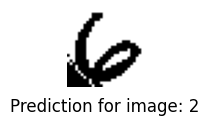

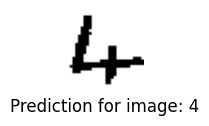

In [14]:
live_test_images(["../data/6.png", "../data/4.png"], loaded_net, device)
# show_img("../data/6.png", 6)